# Fig. 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 30})

import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.max(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy

def get_qtotal(ds): 
    return (ds.qc + ds.qi + ds.qg + ds.qs + ds.qh)*1000

In [3]:
def override_height(ds, z):
    return ds.assign_coords(height=z.values)

## Get Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000
dsref = override_height(dsref,z)

In [5]:
ds08 = override_height(xr.open_mfdataset(data_path + "exp_008.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds17 = override_height(xr.open_mfdataset(data_path + "exp_017.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds28 = override_height(xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)

## Plot Figure

In [6]:
# Customize Colorbar

cmap = plt.get_cmap("magma_r")
cmap_array = cmap(np.linspace(0, 1, 256))

# Set the first portion (0 to 0.1) to white
cmap_array[:int(0.04* 256), :] = [1, 1, 1, 1]  

my_cmap = mcolors.ListedColormap(cmap_array)

In [7]:
dsets = [ None, ds08, ds17,ds28]

unit = f"$\,$kW$\,$m$^-$$^2$"
set_names = ["Reference case", f"50" + unit,  "100" + unit, "200"+ unit]
set_names2 = ["a", "b", "c", "d"]

0
1
2
3


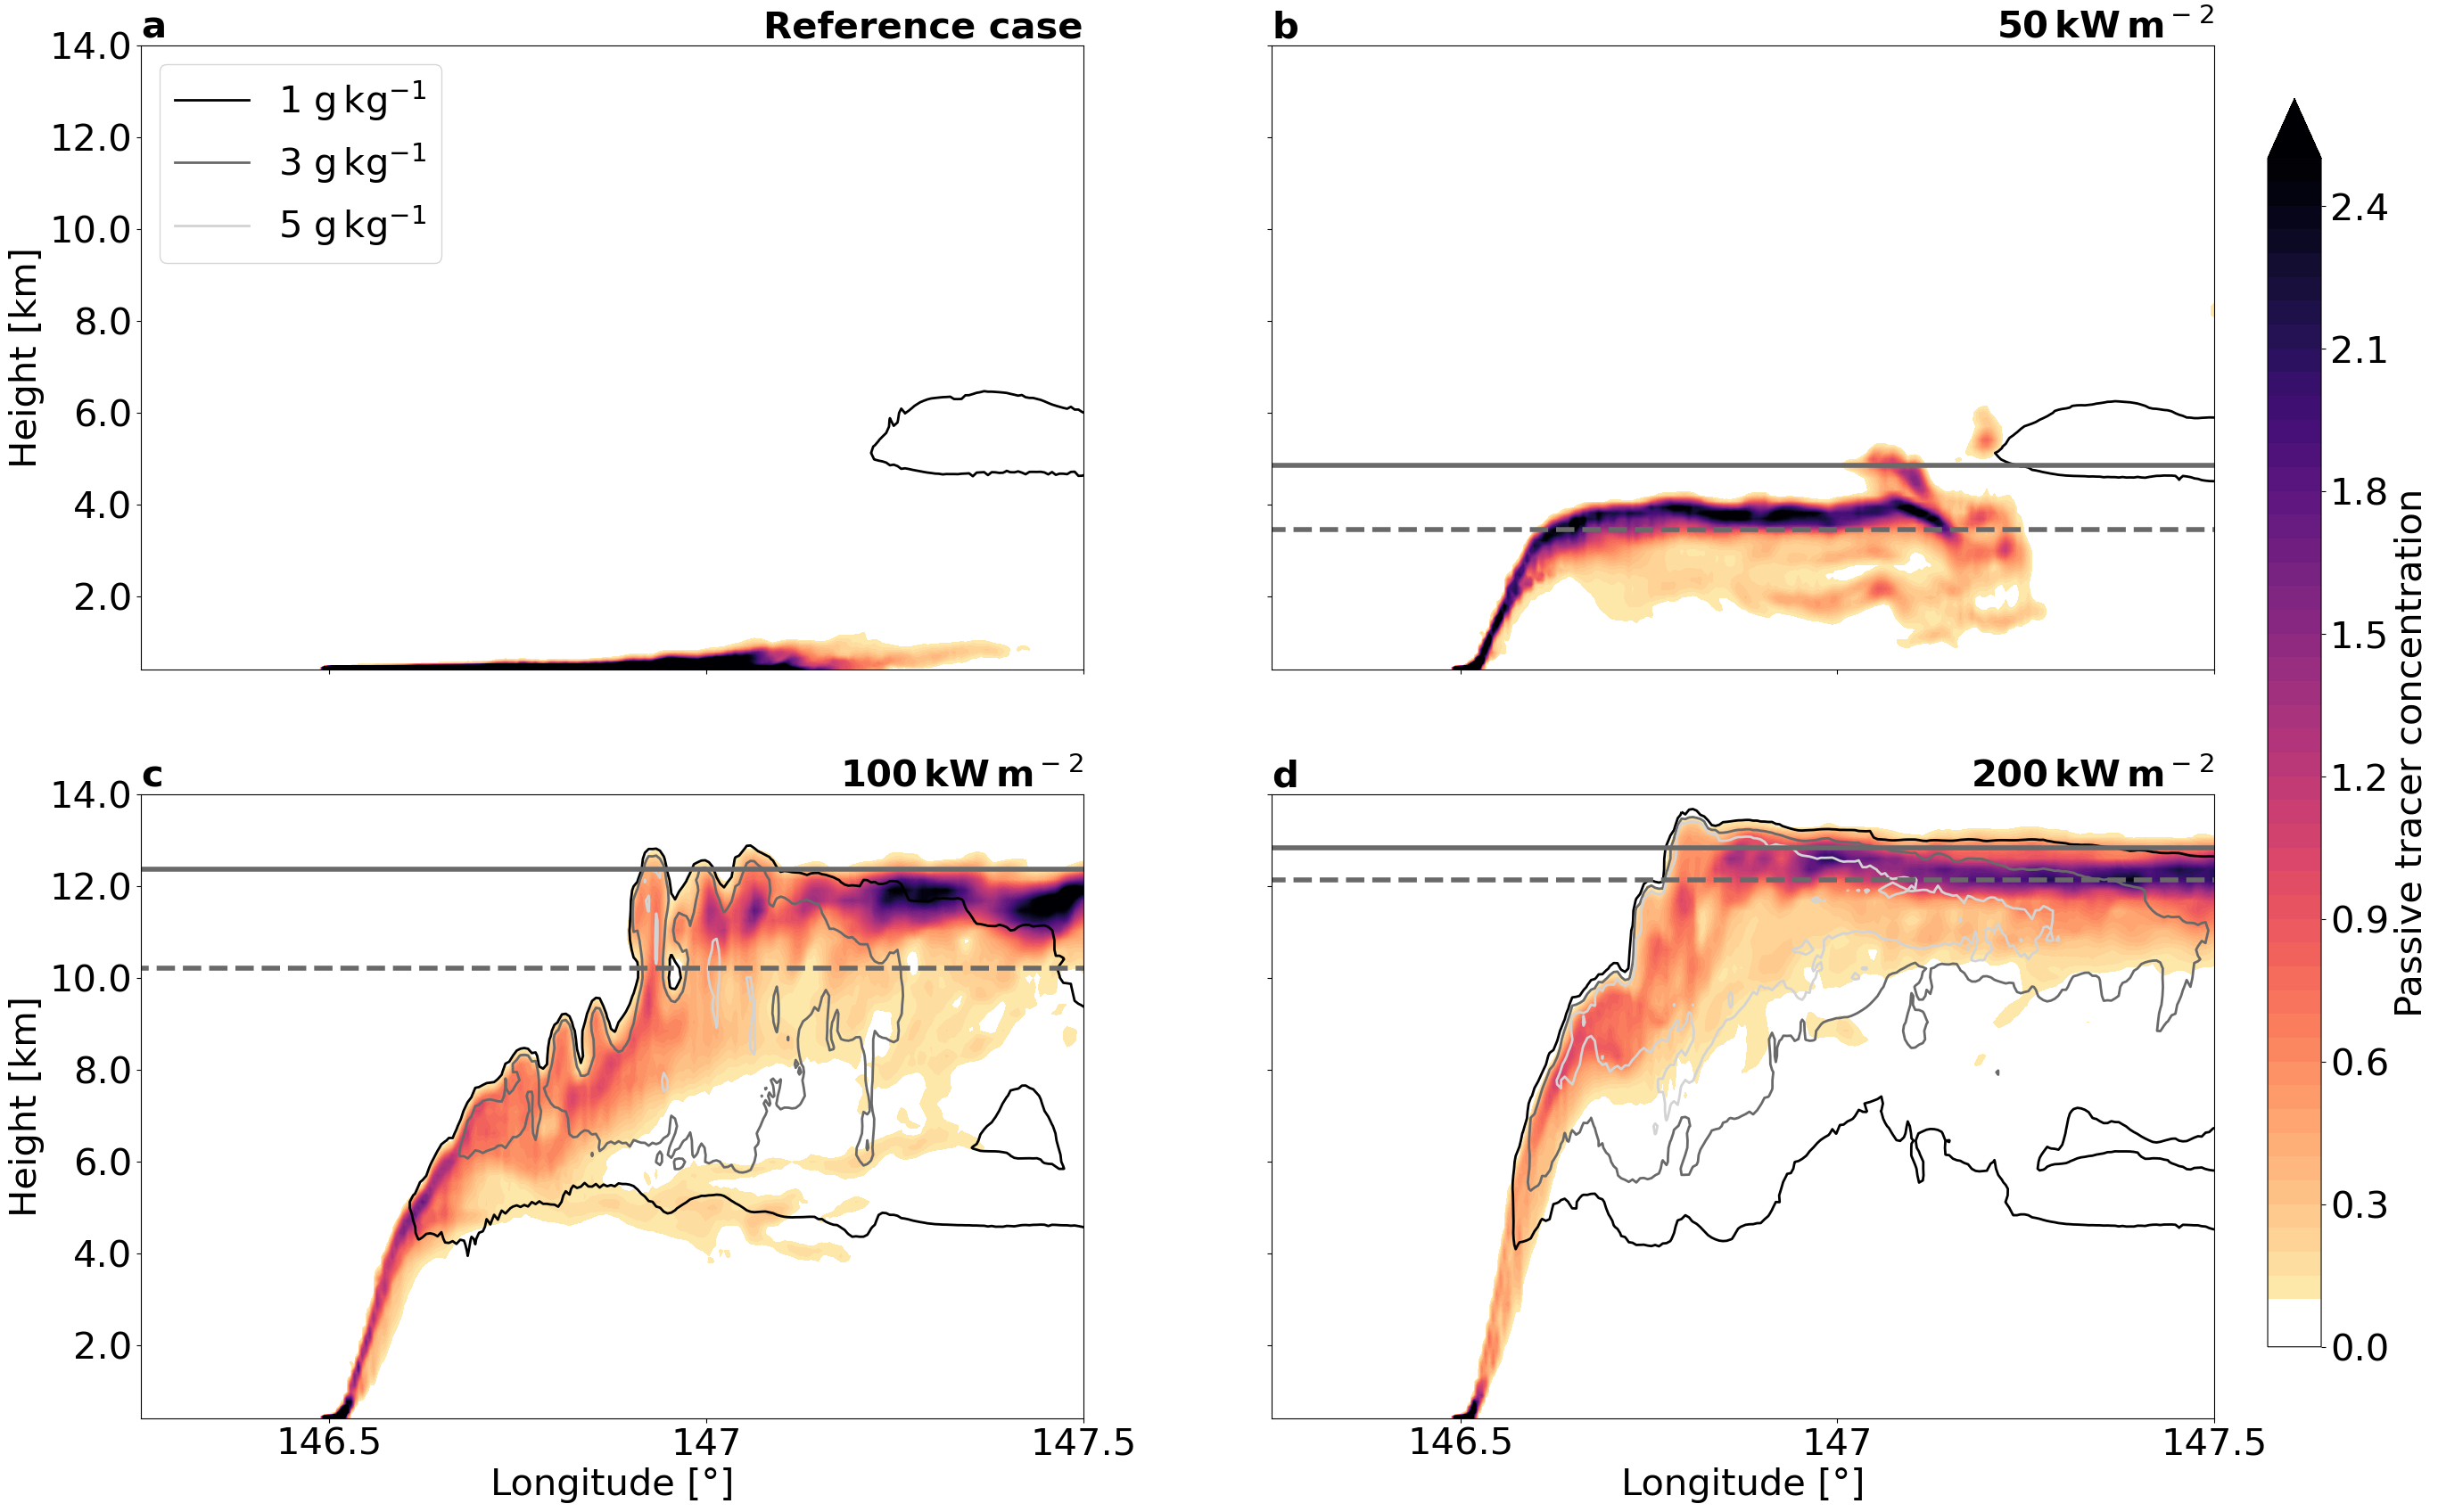

In [8]:
# Create figure and axes
fig, ax = plt.subplots(2, 2, figsize=[30, 20])
levels = np.arange(0.0, 2.51, 0.05)
clevels = [1, 3 ,5]
dlat = 0.35

# Font size for all plots
font_size = 30
var = "Qpassive_1"
time_index = 5

# Define tick values for y and x axes
y_ticks = np.arange(2,14.1,2)
x_ticks = [146.5, 147, 147.5]

# Loop through each subplot
for j, axis in enumerate(ax.reshape(-1)):
    print(j)

    # Plot the first subplot with reference data
    if j == 0:
        c = axis.contourf(
            dsref.lon, dsref.height, dsref[var].mean("lat"), 
            levels=levels, cmap=my_cmap, extend="max"
        )
        CS = axis.contour(dsref.lon, dsref.height, get_qtotal(dsref).max("lat"), 
                          levels = clevels, 
                          colors = ["Black","Dimgrey", "Lightgrey"],
                          linewidths = 2)
        # Define legend elements
        legend_elements = [
        mlines.Line2D([], [], color="Black", linewidth=2, label=r"1 g$\,$kg$^{{-1}}$"),
        mlines.Line2D([], [], color="Dimgrey", linewidth=2, label=r"3 g$\,$kg$^{{-1}}$"),
        mlines.Line2D([], [], color="Lightgrey", linewidth=2, label=r"5 g$\,$kg$^{{-1}}$"),
        ]

        # Add the legend to the figure (adjust location as needed)
        axis.legend(handles=legend_elements, loc="upper left", fontsize=font_size, frameon=True)

        

    
    # Plot subsequent subplots with dataset from `dsets`
    if j >= 1:
        ds = dsets[j]
        c = axis.contourf(
            ds.lon, ds.height, ds[var].mean("lat").isel(time=time_index),
            levels=levels, cmap=my_cmap, extend="max"
        )
        CS = axis.contour(ds.lon, ds.height, get_qtotal(ds).max("lat").isel(time=time_index), 
                          levels = clevels,
                          colors = ["Black","Dimgrey", "Lightgrey"],
                          linewidths = 2)
        # Draw horizontal lines at quantile heights
        
        axis.hlines(
            quantile_height(ds.isel(time=time_index), quantile=0.05), 146, 148,
            color="dimgrey", linestyle="-", linewidth=4
        )
        axis.hlines(
            quantile_height(ds.isel(time=time_index), quantile=0.5), 146, 148,
            color="dimgrey", linestyle="--", linewidth=4
        )

    # Set axis properties
    axis.set_title(set_names[j], fontsize=font_size, fontweight="bold", loc="right")
    axis.set_title(set_names2[j], fontsize=font_size, fontweight="bold", loc="left")
    axis.set_xlim(146.25, 147.5)
    axis.set_ylim(z.min().values, 14)
    axis.set_yticks(y_ticks)
    axis.set_yticklabels(y_ticks, fontsize=font_size)
    axis.set_xticks(x_ticks)
    axis.set_xticklabels(x_ticks, fontsize=font_size)

    # Set axis labels only for the leftmost and bottommost subplots
    if axis.is_first_col():
        axis.set_ylabel('Height [km]', fontsize=font_size)
    else:
        axis.set_yticklabels([])

    if axis.is_last_row():
        axis.set_xlabel('Longitude [°]', fontsize=font_size)
    else:
        axis.set_xticklabels([])

# Add a colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
fig.colorbar(c, cax=cbar_ax, label="Passive tracer concentration")

# Save figure in different resolutions
my_path = "./figs/"
fig.savefig(my_path + 'fig03.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig03_lq.png', dpi=50, bbox_inches='tight')